<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот Ноутбук является Примером/Шаблоном (Baseline) к этому соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

In [ ]:
#!pip install catboost

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from pandas_profiling import ProfileReport
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_selection import f_classif, mutual_info_classif
from pandas import Series
from sklearn.ensemble import RandomForestRegressor

In [2]:
from lazypredict.Supervised import LazyRegressor

C:\Users\cloud\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.1


In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Setup

In [7]:
VERSION    = 16
DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [8]:
!ls '../input'

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [9]:
train = pd.read_csv('df_train_cars.csv') # датасет для обучения модели
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [10]:
train.head(5)

,car_url,brand,bodyType,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,...,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price,city
0,https://auto.ru/cars/used/sale/skoda/octavia/1...,SKODA,лифтбек,золотистый,"Все автомобили, представленные в продаже, прох...",1.8 LTR,152.00,"{'cruise-control': True, 'esp': True, 'airbag-...",Бензин,177000.00,...,автоматическая,EUROPEAN,4.00,Оригинал,передний,Левый,Не требует ремонта,Растаможен,540000.00,Москва
1,https://auto.ru/cars/used/sale/skoda/rapid/110...,SKODA,лифтбек,серый,НЕ ТАКСИ ! НЕ БИТАЯ И НЕ КРАШЕНАЯ ! Хорошая ко...,1.6 LTR,110.00,"{'cruise-control': True, 'esp': True, 'usb': T...",Бензин,23000.00,...,автоматическая,EUROPEAN,1.00,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1610000.00,Москва
2,https://auto.ru/cars/used/sale/skoda/octavia_r...,SKODA,лифтбек,серый,2 Владелец \nДокументы Оригинал \nКомплект Клю...,2.0 LTR,200.00,"{'cruise-control': True, 'esp': True, 'airbag-...",Бензин,221000.00,...,роботизированная,EUROPEAN,2.00,Оригинал,передний,Левый,Не требует ремонта,Растаможен,960000.00,Москва
3,https://auto.ru/cars/used/sale/skoda/octavia_r...,SKODA,лифтбек,зелёный,Продам Skoda Octavia RS (200 л.с) 2012 года вы...,2.0 LTR,200.00,"{'cruise-control': True, 'asr': True, 'tinted-...",Бензин,240000.00,...,роботизированная,EUROPEAN,4.00,Дубликат,передний,Левый,Не требует ремонта,Растаможен,1190000.00,Москва
4,https://auto.ru/cars/used/sale/skoda/octavia/1...,SKODA,лифтбек,чёрный,"Авто в хорошем состоянии,что было сделано по д...",2.0 LTR,140.00,"{'cruise-control': True, 'tinted-glass': True,...",Дизель,275000.00,...,роботизированная,EUROPEAN,3.00,Дубликат,передний,Левый,Не требует ремонта,Растаможен,660000.00,Москва


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48383 entries, 0 to 48382
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_url              48383 non-null  object 
 1   brand                48383 non-null  object 
 2   bodyType             48383 non-null  object 
 3   color                48383 non-null  object 
 4   description          48383 non-null  object 
 5   engineDisplacement   48383 non-null  object 
 6   enginePower          47799 non-null  float64
 7   equipment_dict       48383 non-null  object 
 8   fuelType             47968 non-null  object 
 9   mileage              47968 non-null  float64
 10  modelDate            48383 non-null  float64
 11  model_name           48383 non-null  object 
 12  numberOfDoors        48383 non-null  float64
 13  parsing_unixtime     48383 non-null  float64
 14  priceCurrency        48383 non-null  object 
 15  productionDate       48383 non-null 

In [12]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [14]:
#profile = ProfileReport(train, title='Pandas Profiling Report',)

In [15]:
#profile.to_notebook_iframe()

In [16]:
#profile.to_file("pandas_report_1.html")

## EDA

In [17]:
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест

In [18]:
train['sell_id'] = 0

In [19]:
columns = train.columns.to_list()

In [20]:
test['city'] = 'Москва'
test['price'] = 0

In [21]:
test_df = test[columns]

In [22]:
data = test_df.append(train, sort=False).reset_index(drop=True) # объединяем

In [23]:
cat_cols = []
num_cols = []
bin_cols = []
final_cols = []

In [24]:
unknown_cols = list()

#### bodyType

In [25]:
data.bodyType.value_counts()

внедорожник 5 дв.                     31699
седан                                 28264
лифтбек                                5212
хэтчбек 5 дв.                          4786
универсал 5 дв.                        2725
                                      ...  
фастбек                                   1
пикап одинарная кабина regular cab        1
внедорожник 5 дв. rs                      1
универсал 5 дв. california                1
компактвэн cross                          1
Name: bodyType, Length: 104, dtype: int64

In [26]:
common_bodyType = (data['bodyType'].value_counts(
)[data['bodyType'].value_counts(normalize=True) > 0.005]).to_dict() # словарь с наиболее часто встречающимися типами кузова
list_bodyType = list(common_bodyType.keys()) 
list_bodyType

['внедорожник 5 дв.',
 'седан',
 'лифтбек',
 'хэтчбек 5 дв.',
 'универсал 5 дв.',
 'минивэн',
 'купе',
 'компактвэн',
 'хэтчбек 3 дв.',
 'седан long',
 'пикап двойная кабина']

In [27]:
# редкие заменим на 'other'
data.bodyType = data.bodyType.apply(lambda x: x if x in list_bodyType else 'other') 

In [28]:
data.bodyType.value_counts() 

внедорожник 5 дв.       31699
седан                   28264
лифтбек                  5212
хэтчбек 5 дв.            4786
other                    2952
универсал 5 дв.          2725
минивэн                  1926
купе                     1880
компактвэн               1103
хэтчбек 3 дв.            1073
седан long                872
пикап двойная кабина      577
Name: bodyType, dtype: int64

In [29]:
cat_cols.append('bodyType') #добавим в финальный список

#### brand

In [30]:
%matplotlib inline

<AxesSubplot:>

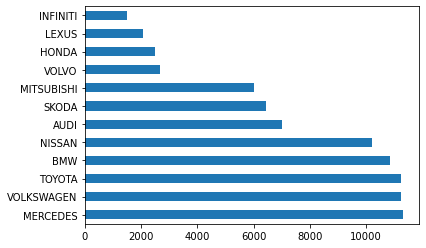

In [31]:
data.brand.value_counts().plot.barh()

In [32]:
cat_cols.append('brand')

## color

In [33]:
data.color.value_counts(normalize=True)

чёрный        0.31
белый         0.20
серый         0.13
серебристый   0.11
синий         0.09
красный       0.04
коричневый    0.04
зелёный       0.02
бежевый       0.02
голубой       0.01
пурпурный     0.01
золотистый    0.01
фиолетовый    0.01
жёлтый        0.00
оранжевый     0.00
розовый       0.00
Name: color, dtype: float64

In [34]:
cat_cols.append('color')

In [35]:
cat_cols

['bodyType', 'brand', 'color']

## description

In [36]:
data.description # описание машин, пока оставим

0        Все автомобили, представленные в продаже, прох...
1        ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...
2        Все автомобили, представленные в продаже, прох...
3        КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...
4        ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...
                               ...                        
83064    Продам. В отличном состоянии! С машиной отдам ...
83065    Пробег 80 500 км. подтвержденный. \n\nЭто макс...
83066    Автомобиль полностью исправен, в хорошем состо...
83067    Автомобиль в отличном состоянии, как по кузову...
83068    Автомобиль отс.крашен бампер. Двигатель отс. М...
Name: description, Length: 83069, dtype: object

In [37]:
unknown_cols.append('description')

## engineDisplacement

In [38]:
data.engineDisplacement.value_counts() 
# сделаем из объема двигателя номинальный признак

2.0 LTR    19966
1.6 LTR    10796
3.0 LTR    10023
1.8 LTR     6073
2.5 LTR     5511
1.4 LTR     4082
3.5 LTR     3706
2.4 LTR     3348
1.5 LTR     2117
4.0 LTR     1246
1.2 LTR     1220
4.4 LTR     1044
2.1 LTR     1035
2.2 LTR      949
1.3 LTR      909
2.8 LTR      873
5.5 LTR      860
4.7 LTR      800
4.5 LTR      795
1.9 LTR      704
3.2 LTR      683
2.7 LTR      656
4.2 LTR      531
2.3 LTR      454
2.9 LTR      449
3.6 LTR      399
3.7 LTR      379
5.6 LTR      346
5.7 LTR      336
5.0 LTR      333
4.6 LTR      317
1.0 LTR      277
6.0 LTR      174
4.8 LTR      161
4.1 LTR      152
0.7 LTR      140
3.3 LTR      137
3.4 LTR      133
2.6 LTR      120
3.8 LTR      119
3.1 LTR      116
1.7 LTR      114
0.0 LTR       92
4.3 LTR       72
6.2 LTR       56
5.4 LTR       55
 LTR          55
5.9 LTR       28
4.9 LTR       26
6.3 LTR       25
5.2 LTR       19
6.6 LTR       15
1.1 LTR       15
5.8 LTR       14
3.9 LTR        9
9.0 LTR        2
0.5 LTR        1
5.3 LTR        1
7.0 LTR       

In [39]:
for i in range(0, len(data.engineDisplacement)):
    if len(data.engineDisplacement[i]) < 7:
        data.engineDisplacement[i] = data.engineDisplacement.value_counts().keys()[0]

In [40]:
data.engineDisplacement.value_counts()

2.0 LTR    20021
1.6 LTR    10796
3.0 LTR    10023
1.8 LTR     6073
2.5 LTR     5511
1.4 LTR     4082
3.5 LTR     3706
2.4 LTR     3348
1.5 LTR     2117
4.0 LTR     1246
1.2 LTR     1220
4.4 LTR     1044
2.1 LTR     1035
2.2 LTR      949
1.3 LTR      909
2.8 LTR      873
5.5 LTR      860
4.7 LTR      800
4.5 LTR      795
1.9 LTR      704
3.2 LTR      683
2.7 LTR      656
4.2 LTR      531
2.3 LTR      454
2.9 LTR      449
3.6 LTR      399
3.7 LTR      379
5.6 LTR      346
5.7 LTR      336
5.0 LTR      333
4.6 LTR      317
1.0 LTR      277
6.0 LTR      174
4.8 LTR      161
4.1 LTR      152
0.7 LTR      140
3.3 LTR      137
3.4 LTR      133
2.6 LTR      120
3.8 LTR      119
3.1 LTR      116
1.7 LTR      114
0.0 LTR       92
4.3 LTR       72
6.2 LTR       56
5.4 LTR       55
5.9 LTR       28
4.9 LTR       26
6.3 LTR       25
5.2 LTR       19
6.6 LTR       15
1.1 LTR       15
5.8 LTR       14
3.9 LTR        9
9.0 LTR        2
0.5 LTR        1
5.3 LTR        1
7.0 LTR        1
Name: engineDi

In [41]:
data.engineDisplacement.isna().value_counts()

False    83069
Name: engineDisplacement, dtype: int64

In [42]:
data1=data.copy()

In [43]:
cat_cols.append('engineDisplacement')

## enginePower

In [44]:
data.enginePower.value_counts()
# сделаем из мощности двигателя номинальный признак

150.0      3405
249.0      2327
110.0      1882
249 N12    1708
150 N12    1699
           ... 
66 N12        1
383 N12       1
430.0         1
417.0         1
402 N12       1
Name: enginePower, Length: 653, dtype: int64

In [45]:
for i in range(0, len(data.enginePower)):
    if type(data.enginePower[i]) is not float:
        data.enginePower[i] = float(data.enginePower[i][:3])

In [46]:
data.enginePower.value_counts()

150.00    5104
249.00    4035
110.00    2921
190.00    2190
105.00    2126
          ... 
522.00       1
524.00       1
646.00       1
650.00       1
30.00        1
Name: enginePower, Length: 356, dtype: int64

In [47]:
data.enginePower.isna().value_counts() 

False    82485
True       584
Name: enginePower, dtype: int64

In [48]:
data.loc[data['enginePower'].isna(), 'enginePower'] = 150

In [49]:
data['enginePower'] = data['enginePower'].apply(pd.to_numeric, errors='coerce')

In [50]:
num_cols.append('enginePower')

## equipment_dict

In [51]:
data.equipment_dict
# тоже признак с доп. опциями, пока оставим

0        {"engine-proof":true,"tinted-glass":true,"airb...
1        {"cruise-control":true,"asr":true,"esp":true,"...
2        {"cruise-control":true,"tinted-glass":true,"es...
3        {"cruise-control":true,"roller-blind-for-rear-...
4        {"cruise-control":true,"asr":true,"esp":true,"...
                               ...                        
83064    {'cruise-control': True, 'engine-proof': True,...
83065    {'cruise-control': True, 'tinted-glass': True,...
83066    {'cruise-control': True, 'engine-proof': True,...
83067    {'engine-proof': True, 'roller-blind-for-rear-...
83068                                                   {}
Name: equipment_dict, Length: 83069, dtype: object

In [52]:
data1=data.copy()

In [59]:
data1=data1.explode('equipment_dict')

In [60]:
data.equipment_dict[35000]

"{'cruise-control': True, 'esp': True, 'airbag-driver': True, 'isofix': True, 'usb': True, 'aux': True, 'electro-window-front': True, 'multi-wheel': True, 'hcc': True, 'spare-wheel': True, 'heated-wash-system': True, 'ashtray-and-cigarette-lighter': True, 'airbag-curtain': True, 'airbag-passenger': True, 'front-centre-armrest': True, 'computer': True, 'seat-transformation': True, 'wheel-power': True, 'alarm': True, 'lock': True, 'fabric-seats': True, 'electro-mirrors': True, 'electro-window-back': True, 'alloy-wheel-disks': True, 'ptf': True, '16-inch-wheels': True, 'rain-sensor': True, 'airbag-side': True, 'mirrors-heat': True, 'voice-recognition': True, 'volume-sensor': True, 'audiosystem-cd': True, 'dark-interior': True, 'cooling-box': True, 'abs': True, 'front-seats-heat': True, 'bluetooth': True, 'wheel-leather': True, 'wheel-configuration2': True, 'wheel-configuration1': True, 'immo': True, 'climate-control-2': True, 'auto-mirrors': True, 'park-assist-r': True, '12v-socket': True

In [57]:
data1.equipment_dict[0]

'{"engine-proof":true,"tinted-glass":true,"airbag-driver":true,"aux":true,"isofix":true,"electro-window-front":true,"ashtray-and-cigarette-lighter":true,"airbag-passenger":true,"computer":true,"high-beam-assist":true,"seat-transformation":true,"isofix-front":true,"wheel-power":true,"alarm":true,"lock":true,"door-sill-panel":true,"fabric-seats":true,"electro-mirrors":true,"airbag-rear-side":true,"electro-window-back":true,"steel-wheels":true,"ptf":true,"16-inch-wheels":true,"rain-sensor":true,"airbag-side":true,"audiosystem-cd":true,"dark-interior":true,"cooling-box":true,"condition":true,"abs":true,"power-child-locks-rear-doors":true,"front-seats-heat":true,"wheel-configuration2":true,"wheel-configuration1":true,"12v-socket":true,"park-assist-r":true}'

In [ ]:
unknown_cols.append('equipment_dict')

## fuelType

In [61]:
data.fuelType.value_counts()

Бензин          32272
бензин          28601
Дизель          13691
дизель           5800
Гибрид           1209
оборудование      557
гибрид            223
Электро           129
Газ               110
электро            55
газ                 7
Name: fuelType, dtype: int64

In [62]:
data.fuelType = data.fuelType.str.lower()

In [63]:
data.fuelType.isna().value_counts() 

False    82654
True       415
Name: fuelType, dtype: int64

In [64]:
data.fuelType = data.fuelType.fillna('бензин') # как самый распространенный тип топлива

In [65]:
cat_cols.append('fuelType')

## mileage

Распределение близко к нмальному, с правым хвостом, возможно, логарифмирование поможет приблизиться к нормальному распределению

In [66]:
data.mileage.median()


140000.0

In [67]:
data.mileage = data.mileage.fillna(140000.0) 


In [68]:
data.mileage.isna().value_counts()

False    83069
Name: mileage, dtype: int64

In [69]:
num_cols.append('mileage')

In [70]:
data['mileage_log'] = np.log(data.mileage + 1)

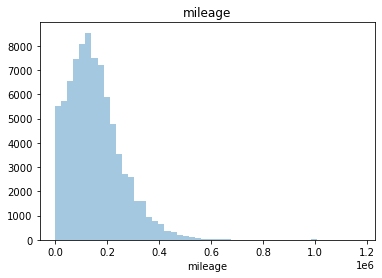

In [71]:
plt.figure()
sns.distplot(data['mileage'], kde = False, rug=False)
plt.title('mileage')
plt.show()

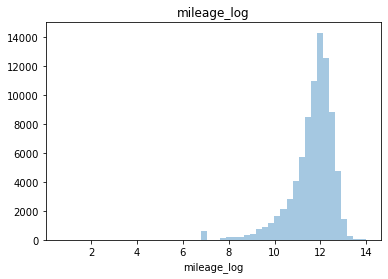

In [72]:
plt.figure()
sns.distplot(data['mileage_log'], kde = False, rug=False)
plt.title('mileage_log')
plt.show()

In [73]:
num_cols.append('mileage_log')

## modelDate

In [74]:
data.modelDate.isna().value_counts()

False    83069
Name: modelDate, dtype: int64

In [75]:
num_cols.append('modelDate')

## productionDate

In [76]:
data['productionDate'].value_counts()

2012.00    6219
2013.00    5742
2014.00    5492
2011.00    5343
2008.00    5136
           ... 
1939.00       1
1970.00       1
1971.00       1
1936.00       1
1904.00       1
Name: productionDate, Length: 71, dtype: int64

In [77]:
data.loc[data['productionDate'] < 1960, 'productionDate'] = 1960

In [78]:
data['productionDate'].isna().value_counts()

False    83069
Name: productionDate, dtype: int64

In [79]:
num_cols.append('productionDate')

Распределение почти такое же как у modelDate, возможно, лучше будет оставить только один из признаков

По отчету по тренировочным данным у нас есть машины до 1937 года, посмотрим на boxplot

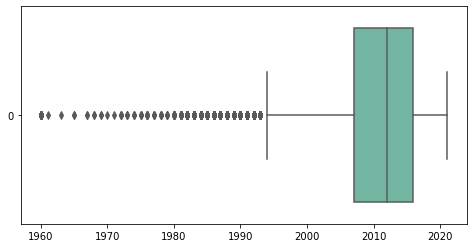

In [80]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=data['productionDate'], orient="h",
                 palette="Set2", whis=1.5);

In [81]:
perc25 = data.productionDate.quantile(0.25)
perc75 = data.productionDate.quantile(0.75)
IQR = perc75 - perc25
f=perc25 - 1.5*IQR
print(perc25, perc75, f)

2007.0 2016.0 1993.5


In [82]:
f=perc25 - 1.5*IQR
f

1993.5

Добавим новый признак, младше 2016 - new, 2007-20016 - not_new, 1993-2007 old, младше 1993 - very old

In [83]:
data['age']=0
data.reset_index(inplace=True)

In [84]:
for i in range(0, len(data.productionDate)):
    if data.productionDate[i] >= 2016:
        data['age'][i] = 'new'
    elif data.productionDate[i] < 2016 and data.productionDate[i] >= 2007:
        data['age'][i] = 'not_new'
    elif data.productionDate[i] < 2007 and data.productionDate[i] >= 1993:
        data['age'][i] = 'old'
    elif data.productionDate[i] < 1993:
        data['age'][i] = 'very_old'

In [85]:
data['age'].value_counts()

not_new     41622
new         22590
old         16583
very_old     2274
Name: age, dtype: int64

In [86]:
cat_cols.append('age')

## model_name

In [87]:
brand_list = [brand for brand in data.brand.unique()]
brand_list

['SKODA',
 'AUDI',
 'HONDA',
 'VOLVO',
 'BMW',
 'NISSAN',
 'INFINITI',
 'MERCEDES',
 'TOYOTA',
 'LEXUS',
 'VOLKSWAGEN',
 'MITSUBISHI']

In [88]:
data[data.brand == 'SKODA']['model_name'].value_counts()

OCTAVIA       3032
RAPID         1118
FABIA          556
YETI           531
SUPERB         489
KODIAQ         418
KAROQ           88
OCTAVIA_RS      69
FELICIA         69
ROOMSTER        50
FABIA_RS         8
FAVORIT          2
120              2
100_SERIES       1
POPULAR          1
Name: model_name, dtype: int64

In [89]:
# хотела выделить самые распространенные бренды в каждой модели, редкие отделить в отдельный вид, 
# но что-то пошло не так

In [90]:
#brand_dict = dict()
#for brand in brand_list:
#    brand_dict[brand] = list((data[data['brand'] == brand]['model_name'].value_counts(
#    )[data['model_name'].value_counts(normalize=True) > 0.001]).keys())
#brand_dict['SKODA'] #словарь с брендами и наиболее популярными моделями

In [91]:
#for brand in brand_list:
#    if data.brand == brand:
#        if data.model_name in brand_dict[brand]:
#            

In [92]:
cat_cols.append('model_name')

## numberOfDoors

In [93]:
data['numberOfDoors'].value_counts()

5.00    47260
4.00    31650
2.00     2690
3.00     1468
0.00        1
Name: numberOfDoors, dtype: int64

In [94]:
data['numberOfDoors'].isna().value_counts()

False    83069
Name: numberOfDoors, dtype: int64

In [95]:
num_cols.append('numberOfDoors')

## parsing_unixtime

In [96]:
# priceCurrency - валюта, везде одинаковая, не нужен

In [97]:
data['parsing_unixtime'].corr(data['price'])

0.45943830555273124

In [98]:
num_cols.append('parsing_unixtime')

## super_gen

In [99]:
data['super_gen'].value_counts() # еще общая информация, частично дублирует уже имеющуюся
# пока уберем

{"id":"6214876","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"MECHANICAL","power":105,"power_kvt":77,"human_name":"1.6 MT (105 л.с.)","acceleration":10.5,"clearance_min":170,"fuel_rate":6.5}                     193
{"id":"20726520","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"AUTOMATIC","power":110,"power_kvt":81,"human_name":"1.6 AT (110 л.с.)","acceleration":11.7,"clearance_min":163,"fuel_rate":5.9}                     159
{"id":"4561004","displacement":1798,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"AUTOMATIC","power":152,"power_kvt":112,"human_name":"1.8 AT (152 л.с.)","acceleration":8.8,"clearance_min":164,"fuel_rate":7.7}                      148
{'gear_type': 'FORWARD_CONTROL', 'engine_type': 'GASOLINE', 'transmission': 'MECHANICAL', 'id': '6214876', 'name': '', 'nameplate': '', 'displacement': 1598, 'power': 105, 'power_kvt': 77, 'human_name': '1.6 MT (105 л.с.

In [ ]:
data['super_gen']=data['super_gen'].apply(lambda x: eval(x))

In [ ]:
unknown_cols.append('super_gen')

## vehicleTransmission

In [ ]:
data['vehicleTransmission'].value_counts()

In [ ]:
data['vehicleTransmission'].isna().value_counts()

In [ ]:
data['vehicleTransmission']=data['vehicleTransmission'].fillna('автоматическая')

In [ ]:
cat_cols.append('vehicleTransmission')

## Владельцы

In [ ]:
data['Владельцы'].value_counts()

In [ ]:
def convert_to_int(data):
    for s in re.findall('\d', str(data)):
        s = int(s)
        return s

In [ ]:
data['Владельцы'] = data['Владельцы'].apply(convert_to_int)

In [ ]:
data['Владельцы'].value_counts()

# если не указано предполагаем худшее

In [ ]:
data['Владельцы'] = data['Владельцы'].fillna(3)

In [ ]:
data.loc[data['Владельцы'] > 3, 'Владельцы'] = 3

In [ ]:
data['Владельцы'].value_counts()

In [ ]:
num_cols.append('Владельцы')

## Привод

In [ ]:
data['Привод'].value_counts() 


In [ ]:
data['Привод'] = data['Привод'].fillna('передний')

In [ ]:
data['Привод'].isna().value_counts() 

In [ ]:
cat_cols.append('Привод')

## vendor

In [ ]:
data['vendor'].value_counts() 

In [ ]:
cat_cols.append('vendor')

## ПТС

In [ ]:
data['ПТС'].value_counts() 

In [ ]:
data['ПТС'] = data['ПТС'].fillna("Оригинал")

In [ ]:
bin_cols.append('ПТС')

## Руль

In [ ]:
#data1=data.copy()

In [ ]:
data['Руль'] = data['Руль'].fillna("Левый")

In [ ]:
data['Руль'].value_counts() 

In [ ]:
data['Руль'].isna().value_counts() 

In [ ]:
bin_cols.append('Руль')

## city

In [ ]:
cat_cols.append('city')

## price

целевой признак
неплохо бы учесть изменение цен, судя по motor.ru и autonews.ru в среднем цены выросли процентов на 25-30, то есть наши цены нужно умножить на коэффициент равный 0.8 - 0.75

In [ ]:
data.price = data.apply(lambda x: x.price if x.price == 0 else x.price * 0.8, axis=1)

In [ ]:
plt.figure()
sns.distplot(data['price'], kde = False, rug=False)
plt.title('price')
plt.show()

In [ ]:
num_cols

In [ ]:
data.info()

In [ ]:
cols = ['sample', 'sell_id', 'price']

In [ ]:
train_1=data[data['sample'] == 1]
train_1.info()

In [ ]:
num_cols

In [ ]:
num_cols = pd.Series(
    f_classif(
        train_1[num_cols],
        train_1["price"],
    )[0],
    index=num_cols,
)
num_cols.sort_values(inplace=True, ascending=False)
num_cols.plot(kind="bar", figsize=(15, 3))
plt.title("Significance of num variables")

т.к. коррелция между modelDate и productionDate по отчету большая, оставим признак, который больше влияет на модель
еще большая корреляция между mileage и productionDate, что логично, чем старше машина, тем больше пробег, можно попробовать создать признак на основе этих двух

In [ ]:
data['mileage_year'] = 0
data['mileage_per_year'] = 0

In [ ]:
data

In [ ]:
data

In [ ]:
for i in range(0, len(data.productionDate)):
    data['mileage_year'][i] = data.mileage[i]/(data.productionDate[i])

In [ ]:
for i in range(0, len(data.productionDate)):
    if data.productionDate[i] != 2021:
        data['mileage_per_year'][i] = data.mileage[i]/(2021.0 - data.productionDate[i])
    else:
        data['mileage_per_year'][i] = data.mileage[i]

In [ ]:
data['mileage'].corr(data['productionDate'])

In [ ]:
num_cols = ['mileage_per_year', 'productionDate', 'mileage_year', 'mileage_log', 'enginePower', 'Владельцы']

In [ ]:
train_1=data[data['sample'] == 1]
train_1.info()

In [ ]:
num_cols = pd.Series(
    f_classif(
        train_1[num_cols],
        train_1["price"],
    )[0],
    index=num_cols,
)
num_cols.sort_values(inplace=True, ascending=False)
num_cols.plot(kind="bar", figsize=(15, 3))
plt.title("Significance of num variables")

In [ ]:
num_cols = ['productionDate', 'mileage_year', 'mileage_log', 'enginePower']

In [ ]:
for colum in cat_cols:
    train_1[colum] = train_1[colum].astype('category').cat.codes

In [ ]:
train_1[cat_cols]

In [ ]:
train_1.info()

In [ ]:
label_encoder = LabelEncoder()
for column in bin_cols:
    train_1[column] = label_encoder.fit_transform(train_1[column])
    print(dict(enumerate(label_encoder.classes_)))

In [ ]:
imp_cat = Series(mutual_info_classif(train_1[bin_cols + cat_cols], train_1['price'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

бинарные признаки уберем совсем

In [ ]:
columns = cat_cols + num_cols + cols
train_1 = train_1[columns]

In [ ]:
plt.rcParams['figure.figsize'] = (12,12)
sns.heatmap(train_1.drop(['sample'], axis=1).corr().abs(),annot=True, fmt=".2f", linewidths=0.1, cbar=False)

In [ ]:
cat_cols

In [ ]:
columns = ['model_name', 'enginePower', 'age', 'bodyType', 'brand', 'color', 'vehicleTransmission', 'Привод', 
           'mileage_log', 'sample', 'sell_id', 'price']

## Data Preprocessing

In [ ]:
columns = cat_cols + num_cols + cols
data = data[columns]
#columns = ['bodyType', 'brand', 'productionDate', 'engineDisplacement', 'mileage', 'price', 'sample']
#data = data[columns]

In [ ]:
train = data[data['sample'] == 1] # помечаем где у нас трейн
test = data[data['sample'] == 0] # помечаем где у нас тест

In [ ]:
#train.dropna(subset=['productionDate','mileage'], inplace=True)
train.dropna(subset=['price'], inplace=True)

In [ ]:
# для baseline просто возьму пару схожих признаков без полной обработки
#columns = ['bodyType', 'brand', 'productionDate', 'engineDisplacement', 'mileage']
df_train = train[columns]
df_test = test[columns]

In [ ]:
y = train['price']

## Label Encoding

In [ ]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
#df_train['sample'] = 1 # помечаем где у нас трейн
#df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [ ]:
for colum in cat_cols:
    data[colum] = data[colum].astype('category').cat.codes

In [ ]:
data

In [ ]:
X = data.query('sample == 1').drop(['sample', 'price'], axis=1)
X_sub = data.query('sample == 0').drop(['sample','price'], axis=1)

## Train Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [ ]:
#tmp_train = X_train.copy()
#tmp_train['price'] = y_train

In [ ]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
#predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
#print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

# # Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

In [ ]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [ ]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Вот так просто со старта, даже не трогая сами данные и не подбирая настройки catboosta, получаем модель с уровнем ошибки в 18%!

In [ ]:
columns = ['bodyType', 'brand', 'productionDate', 'engineDisplacement', 'mileage_log', 'price', 'sample']
data = data[columns]

In [ ]:
columns = ['bodyType', 'brand', 'productionDate', 'engineDisplacement', 'mileage_log']
df_train = train[columns]
df_test = test[columns]

In [ ]:
y = train['price']

In [ ]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [ ]:
for colum in ['bodyType', 'brand', 'engineDisplacement']:
    data[colum] = data[colum].astype('category').cat.codes

In [ ]:
data

In [ ]:
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
#clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=mape)
#models,predictions = clf.fit(X_train, X_test, y_train, y_test)

In [ ]:
#print(models)

Использовала lazypredict на малом объеме данных, с полным объемом не справляется, зависает, он выдал наилучшей модель ExtraTreesRegressor, а если еще и прологарифмировать y, то получается неплохой результат, нужно попробовать подобрать гиерпараметры

# ExtraTreesRegressor

In [ ]:
reg = ExtraTreesRegressor(n_estimators=100, random_state=42).fit(X_train, np.log(y_train))
predict = np.exp(reg.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
n_estimators = [100, 150, 200, 250, 300, 350, 400, 450, 500]
max_features = ['auto', 'sqrt']
max_depth = [10, 15, 20, 25]
max_depth.append(None)
min_samples_split = [2,3,4,5,6,7,8,9,10]
min_samples_leaf = [1,2,3,4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model_random = RandomizedSearchCV(estimator=reg, param_distributions=random_grid, n_iter=10, 
                               cv=3, verbose=2, random_state=42, n_jobs=-1)
model_random.fit(X_train, y_train)

model_random.best_params_



In [ ]:
reg = ExtraTreesRegressor(random_state=RANDOM_SEED, 
                            n_jobs=-1, 
                            verbose=1, 
                            n_estimators = 400, 
                            min_samples_split = 9, 
                            min_samples_leaf = 2, 
                            max_features = 'auto', 
                            max_depth = 25, 
                            bootstrap = False)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")



In [ ]:
reg.fit(X_train, np.log(y_train))
y_pred = np.exp(reg.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Не очень то настройка гиперпараметров помогла

# RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(random_state=RANDOM_SEED)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

In [ ]:
rfr.fit(X_train, np.log(y_train))
y_pred = np.exp(rfr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

In [ ]:
n_estimators = [100, 150, 200, 250, 300, 350, 400]
max_features = ['auto', 'sqrt']
max_depth = [10, 15, 20, 25]
min_samples_split = [2, 4, 6, 8, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


model_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid, n_iter=10, 
                               cv=3, verbose=2, random_state=42, n_jobs=-1)
model_random.fit(X_train, y_train)



In [ ]:
model_random.best_params_

In [ ]:
rfr = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1,verbose=1, n_estimators=100,
                             min_samples_split=10, min_samples_leaf=2, max_features='sqrt',
                             max_depth=25, bootstrap=False)

rfr.fit(X_train, np.log(y_train))

y_pred = np.exp(rfr.predict(X_test))

print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

# GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor(random_state=RANDOM_SEED).fit(X_train, np.log(y_train))
y_pred = np.exp(model.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

# BaggingRegressor

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import make_regression

In [ ]:
model = RandomForestRegressor(random_state=RANDOM_SEED).fit(X_train, np.log(y_train))
y_pred = np.exp(model.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

# XGBRegressor

In [ ]:
from  xgboost import XGBRegressor

In [ ]:
model = XGBRegressor(random_state=RANDOM_SEED).fit(X_train, np.log(y_train))
y_pred = np.exp(model.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
#Стекинг
#
#Объединим BaggingRegressor, ExtraTreesRegressor и RandomForestRegressor. В качестве мета-алгоритма используем LinearRegression

estimators = [
    ('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, 
                            n_jobs=-1, 
                            verbose=1, 
                            n_estimators = 400, 
                            min_samples_split = 9, 
                            min_samples_leaf = 2, 
                            max_features = 'auto', 
                            max_depth = 25, 
                            bootstrap = False)),
    ('xgb', XGBRegressor(random_state=RANDOM_SEED)),
    ('cfr', RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1,verbose=1, n_estimators=100,
                             min_samples_split=10, min_samples_leaf=2, max_features='sqrt',
                             max_depth=25, bootstrap=False))]

stack_log = StackingRegressor(estimators=estimators,
                              final_estimator=LinearRegression()
                              )

stack_log.fit(X_train, np.log(y_train))

y_pred = np.exp(stack_log.predict(X_test))

print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred) * 100):0.2f}%.")



### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [ ]:
#np.log(y_train)

In [ ]:
#model = CatBoostRegressor(iterations = 5000,
#                          random_seed = RANDOM_SEED,
#                          eval_metric='MAPE',
#                          custom_metric=['R2', 'MAE'],
#                          silent=True,
#                         )
#model.fit(X_train, np.log(y_train),
#         #cat_features=cat_features_ids,
#         eval_set=(X_test, np.log(y_test)),
#         verbose_eval=0,
#         use_best_model=True,
#         #plot=True
#         )
#
#model.save_model('catboost_single_model_2_baseline.model')

In [ ]:
#predict_test = np.exp(model.predict(X_test))
#predict_submission = np.exp(model.predict(X_sub))

In [ ]:
#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Как видим точность возросла до 15%, а что будет на ЛБ?

Для выбора оптимального алгоритма я собиралась использовать LazyRegressor, но ноутбук перезапускался из-за превышения объема памяти, поэтому пришлось экспериментрировать вручную.

После проверки предложенных в baseline моделей (наивной и catBoost) я решила начать с решающего дерева, прежде, чем переходить к ансамблям. Решающее дерево уже само по себе относительно неплохо сработало (МАРЕ около 23%), поэтому в качестве ансамбля я решила опробовать RandomForest (который в последствии оказался лучшей моделью).

Далее возникли проблемы с настройкой гиперпараметров, т.к. при запуске RandomizedSerchCV и GridSearchCV снова возникла проблема с перезапуском ноутбука. Код для уменьшения объема исользуемой памяти, найденный мной на StackOverFlow, проблему не решил. Было решено заниматься настройкой гиперпараметров только для тех моделей, которые с параметрами по умолчанию уже дают хороший результат. Пришлось завести дополнительный ноутбук в Юпитере для подбора гиперпараметров. НО: скачать train датасет с Kaggle не вышло, поэтому в Юпитере я тестировала модель только на train_extra, вероятно поэтому подобранные гиперпараметры не улучшали качество моделей на Kaggle.

В результате всех этих приключений и подбора корригирующего коэффициента для цен мне удалось получить значение метрики МАРЕ 13,58 на ЛБ после использования случайного леса с параметрами по умолчанию. На чем я и решила остановиться

# Submission

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

В итоге получили **MAPE 27%** на ЛБ!

Большая разница в ошибке может указывать на то что тест и трейн имеют различия по выборке или то что данные в трейне могли уже устареть и их нужно обновлять.

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные 
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing